In [1]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.insert(0, "../src")

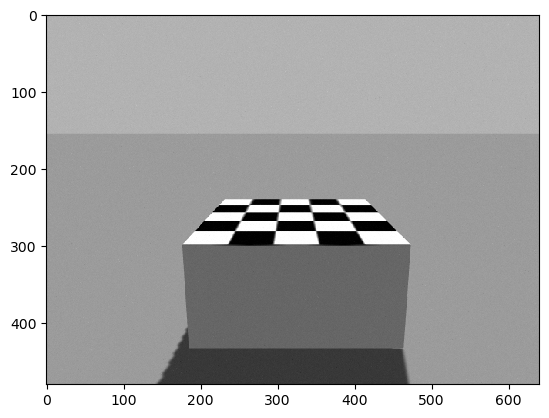

In [29]:
from camera import move_camera_pos, get_model_state, get_camera_info, get_camera_image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import rospy

rospy.init_node("camera_test")

# current default as of 2023-01-18
move_camera_pos(-2, 0, 1, pitch=0.2)
plt.imshow(get_camera_image())
plt.show()

In [31]:
# NOTE: if we try to get the corners using the default perspective, we fail
move_camera_pos(-2, 0, 1, pitch=0.2)
img = get_camera_image()
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, corners = cv2.findChessboardCorners(gray, (4, 4), None)
ret, corners

(False, None)

So it turns out that there are some weird things to consider when using `cv2.findChessboardCorners()`.

- https://stackoverflow.com/questions/17665912/findchessboardcorners-fails-for-calibration-image
- https://stackoverflow.com/questions/19190484/what-is-the-opencv-findchessboardcorners-convention

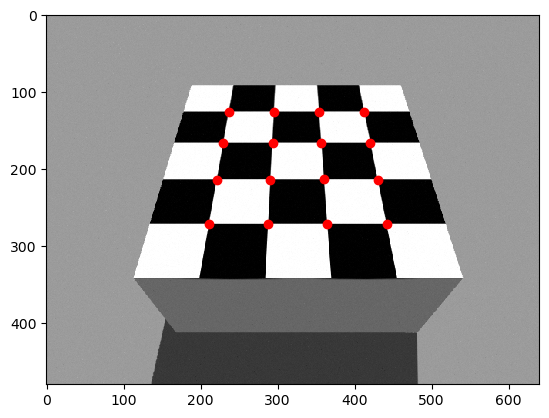

(16, 2)

In [42]:
move_camera_pos(-1, 0, 1.5, pitch=0.9)
img = get_camera_image()

# let's try to get the chessboard corners
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, corners = cv2.findChessboardCorners(gray, (4, 4), None)
# delete axis 1
corners = corners.squeeze(1)

# we found corners, so let's just draw them using a scatter plot
plt.imshow(img)
plt.scatter(corners[:, 0], corners[:, 1], c="r")
plt.show()

corners.shape

Let's perform DLT with this data now and see what we get.
The the top left corner will be our origin.

Some follow up questions:

- How do we deal with depth? When we put something on the surface, how can we tell where the top is?

In [43]:
corners

array([[236.58987 , 125.98596 ],
       [295.42648 , 125.99839 ],
       [353.99692 , 126.036934],
       [412.36923 , 126.05786 ],
       [229.48633 , 166.38132 ],
       [293.2991  , 166.27077 ],
       [356.6344  , 166.28293 ],
       [420.44702 , 166.40735 ],
       [221.57759 , 213.58418 ],
       [290.47043 , 213.56389 ],
       [360.45023 , 213.54529 ],
       [429.67996 , 213.5693  ],
       [211.00072 , 271.40237 ],
       [287.5495  , 271.48328 ],
       [364.50336 , 271.48563 ],
       [441.54916 , 271.44498 ]], dtype=float32)

In [46]:
# assign each point in a 4x4 grid a value between 0 and 100
points = []
for i in range(4):
    for j in range(4):
        points.append((i, j, 50))
points = np.array(points)
points.shape

(16, 3)

In [47]:
# now let's form the A matrix for the DLT
corners.shape

(16, 2)